In [1]:
# import torch
# from torch import Tensor
# import torch.distributions as dist
import numpy as np
from matplotlib import pyplot as plt

## 1. Hidden states and observations

### 1.1 Full Bayesian Inference

- We have an agent which believes its environment can be in one of the 2 states s $\in \{0,1\}$. 
- each of these states can cause one of 3 possible observations o $\in \{0,1,2\}$, 
- The states can cause an observation with probability p(o|s)

For example, states are weather outside (rain, no rain) and observations are the light levels you see coming through the window, without actually looking through the window (low, medium, high)

- The Agents model consists of (prior) beliefs over states p(s), and the state-observation mapping p(o|s)


The agent can make an observation and then update its beliefs about the states using bayes rule.
Another way to say this is that the agents prior beliefs p(o) are updated to form posterior beliefs p(s|o) in response to some sensory information by the use of the agents model of likelihood attributed to observations of given states, p(o|s).

$$ p(s|o) = \frac{p(o|s)p(s)}{p(o)} = \frac{p(o|s)p(s)}{\sum_{s}p(o|s)p(s)}$$ 


The following code gives an prior distribution over two states and a likelihood mapping matrix which for each observation gives a likelihood for each state.

In [6]:
print(f"likelihood = {p_o_s[:, 1]}")
print(f"prior = {p_s}")
print(f"evidence = {sum(p_o_s[:, 1] * p_s)}")
print(f"joint = {p_o_s[:, 1] * p_s}")
print(f"posterior = {p_o_s[:, 1] * p_s / sum(p_o_s[:, 1] * p_s)}")

likelihood = [0.3 0.3]
prior = [0.7 0.3]
evidence = 0.3
joint = [0.21 0.09]
posterior = [0.7 0.3]


In [2]:
import numpy as np

# Prior on two possible states
p_s = np.array([0.7, 0.3])

# p(o|s) Likelihood mapping from states to observations
p_o_s = np.array(
    [
        [0.1, 0.3, 0.6],  # Row 0: Probabilities for observations O=0, O=1, O=2 when in state S=0
        [0.6, 0.3, 0.1],  # Row 1: Probabilities for observations O=0, O=1, O=2 when in state S=1
    ]
)

# observations
observations = [0, 1, 2]

posteriors = []
for observation in observations:
    # likelihood of the observation given all states
    likelihood = p_o_s[:, observation]
    
    # Calculate the posterior: p(S|O=observation)
    prior = p_s
    evidence = sum(likelihood * prior)  # Normalization term
    posterior = likelihood * prior / evidence
    posteriors.append(posterior)
    
    print(f"Posterior distribution for observation O={observation}: {posterior}")

Posterior distribution for observation O=0: [0.28 0.72]
Posterior distribution for observation O=1: [0.7 0.3]
Posterior distribution for observation O=2: [0.93333333 0.06666667]


In [4]:
# Prior on two possible states
prior = np.array([0.7, 0.3])

# p(o|s) Likelihood mapping from states to observations. 
# Can view columns as likelihood of state give an observation and rows as prob dist over observations given a state
likelihoods = np.array(
    [
        [0.1, 0.3, 0.6],
        [0.6, 0.3, 0.1],
    ]
)

# Now say with observe o=1 (from options of 0,1,2)
# we can calculate the posterior p(s|o=2) = p(o=2 |s)p(s) / p(o)
likelihood = likelihoods[:, 1] # p(o=1 | s)
evidence = sum(likelihood * prior) # this is a sum over states. p(o) is p(o, s) with s marginalized out
posterior = likelihood * prior / evidence

# In this case the likelihood for o=1 says its equally likely to be in state 0 or state 1
# i.e we gain no new information about the states from the observation 
# so the posterior remains identical to the prior before we made an observation
posterior

array([0.7, 0.3])

We can now compute the posterior given each of the 3 possible observations

In [5]:
def posterior(prior, A, observation):
    likelihood = A[:, observation]
    evidence = sum(likelihood * prior) # note this is a sum over states p(o) is p(o, s) with s marginalized out
    posterior = likelihood * prior / evidence
    return posterior

# Given the prior prefers the first state s=0, 
# o=2: which has a high likelihood for s=0 and swings the posterior beliefs largely in favour of s=0
# o=1: which has a high likelihood for s=1 and swings the posterior beliefs slighlty in favour of s=1 but 
# moderated by the prior 
for o in [0,1,2]:
    print(f"p(s|o={o}) = {posterior(p_s, p_o_s, o)}")


p(s|o=0) = [0.28 0.72]
p(s|o=1) = [0.7 0.3]
p(s|o=2) = [0.93333333 0.06666667]


### 1.2 Variational Inference 

The problem with simply computing the true posterior with bayes rule is that the evidence,

$$p(o) = \sum_{s} p(o,s) = \sum_{s} p(o|s)p(s)$$

which normalises the joint (prior * likelihood) is not computationally tractable when the state space becomes large.

Instead we search for some distibution over states q(s) (known as the surrogate/approximate/variational posterior) and try to minimise the distance (KL divergence) between it and the true posterior. 

This difference gives rise to the equality (skipping some algebra):

$$
\begin{split}
D_{KL}[q(s)||p(s|o)] &= \sum_{s} q(s) \ln\frac{q(s)}{p(s|o)} \\
                     &=\underbrace{\sum_{s} q(s) \ln\frac{q(s)}{p(o, s)}}_{F} + \ln p(o)
\end{split}

$$

The issue with minimising the KL term on the left directly is that we dont know the true posterior p(s|o) (if we did we would be done anyway!)

The final term is the model evidence, another term which is intractable. Again if we could compute the evidence we would be OK as we could simply use bayes rule directly to compute the posterior.

The 1st term on the right is known as the "variational free energy" $F$ and is composed of terms that we actually have access to (the joint and variational distributions).

The free energy is commonly written in the following two equivalent forms:

$$
\begin{split}
F &= \mathbb{E}_{q(s)}[\ln q(s) - \ln p(o, s) ] \\
  &= \underbrace{D_{KL}[q(s)||p(s|o)]}_{\text{Divergence}} - \underbrace{\log p(o)}_{\text{Evidence}} \\
  &= \underbrace{D_{KL}[q(s)||p(s)]}_{\text{Complexity}} - \underbrace{\mathbb{E}_{q(s)}[\ln p(o | s)]}_{\text{Accuracy}}
\end{split}
$$

The first form shows that if we can find an variational posterior which is exactly equal to the true posterior the divergence terms becomes zero and the free energy becomes exactly equal to the evidence. This shows that free energy is a lower bound on the model evidence and this is why it is often referred to as the Evidence Lower Bound or ELBO. 

Given that under some obervations the evidence term is fixed, we can minimise F term as a proxy for minimising the KL divergence term. Finding the q(s) which minimises variational free energy is known as "Variational Inference".

The final form here shows that in minimising free energy we are looking for an approximate posterior which is minimally complex (similar to our prior beliefs about states s) while also being highly accurate (maximising the likelihood of our observations o).

This is a useful form as unlike the Divergence/Evidence form it is composed of terms we can compute (the prior, the likelihood and the variational posterior). This form is commonly used as the objective/loss function which is optimised to perform variational inference. For example this is exactly the loss function which is used to train variational autoencoders.

### 1.3 Back to the toy example


Below we plot the free energy for all possible variational distributions in the toy example (i.e all possible probabilities of state 0 and 1).

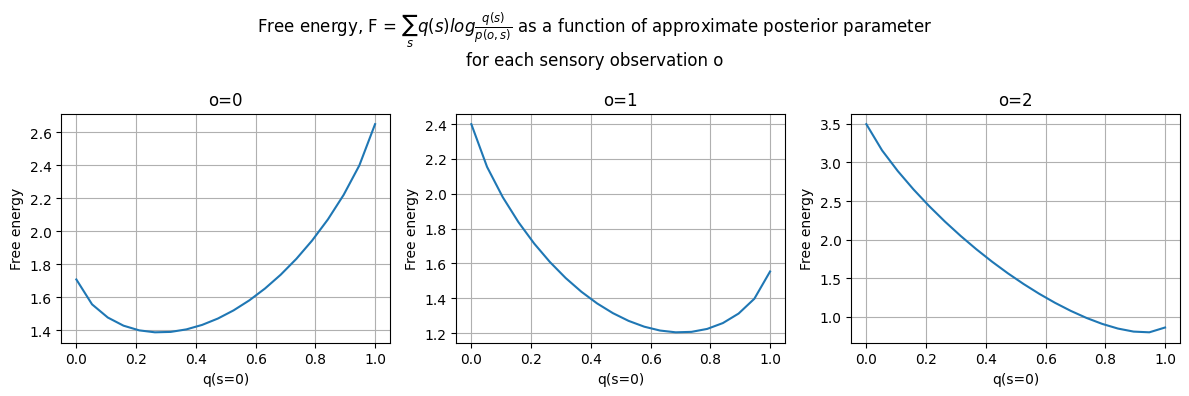

In [6]:
# We are now saying evidence is intractible so need an approx posterior q_s

# Define how free energy is calculated from a given q_s
var_free_energy = lambda q_s, likelihood, prior: sum(q_s * np.log(q_s / (likelihood * prior)))

# We can go through a range of possible state probabilities,
# which in the case of a categorical distribution is also the parameters
# of our approximate posterior. There are only 2 states so this is easy as there
# is only 1 parameter.
es = {"o=0": [], "o=1": [], "o=2": []}
q0s = np.linspace(0.001, 0.999, 20)
for q0 in q0s:
    q_s = np.array([q0, 1 - q0])

    es["o=0"].append(var_free_energy(q_s, p_o_s[:, 0], p_s))
    es["o=1"].append(var_free_energy(q_s, p_o_s[:, 1], p_s))
    es["o=2"].append(var_free_energy(q_s, p_o_s[:, 2], p_s))

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(q0s, es["o=0"])
axs[1].plot(q0s, es["o=1"])
axs[2].plot(q0s, es["o=2"])

axs[0]

for i, ax in enumerate(axs):
    ax.grid()
    ax.set_title(f"o={i}")
    ax.set_xlabel("q(s=0)")
    ax.set_ylabel("Free energy")

fig.suptitle(
    "Free energy, F = $\sum_{s} q(s) log\\frac{q(s)}{p(o, s)}$ as a function of approximate posterior parameter"
    + "\nfor each sensory observation o"
    )
fig.tight_layout()

You can see in the plots above that for each sensory observation the minimum of the free energy corresponds to a posterior  parameter equal to that found from the exact posterior computed before:
```
q(s|o=0) = [0.28 0.72]
q(s|o=1) = [0.7 0.3]
q(s|o=2) = [0.93333333 0.06666667]
```

We have found this approximate posterior without needing to compute the (normally intractable) evidence p(o).

### Active inference - Incorprating actions over time

We now include possible sequences of actions u, known as policies $\pi$

In [ ]:
# State transistion matrices parameterising p(s_t| s_t-1, pi)
B1 = np.array([
    [1, 0],
    [0, 1],
])
B2 = np.array([
    [0.5, 0.5],
    [0.5, 0.5],
])

# p(o|s) Likelihood mapping from states to observations. 
# Can view columns as likelihood of state give an observation 
# and rows as prob dist over observations given a state
A = np.array(
    [
        [0.1, 0.3, 0.6],
        [0.6, 0.3, 0.1],
    ]
)

# T=1
# Approx posterior
q_s_1 = np.array([0.7, 0.3])

# T=2 (the future)
# For a particular action B1

prior = B1 @ q_s_1 # q(s | pi) - new prior after state transition,
joint = A.T * prior # q(s, o| pi)
marginal = joint.sum(axis=1) # q(o|pi) - normally intractable

# p(s | o, pi)
posterior = joint / marginal[:, np.newaxis]

# evolutionary prior 
p_o = np.array([0.2, 0.8, 0.0])

future_joint = posterior.T * p_o

print(f"{prior = }")
print(f"{joint.T = }")
print(f"{marginal = }")
print(f"{posterior.T = }")
print(f"{future_joint = }")

: 

#### Expected free energy

While the goodness of model fit can be scored by the variational free energy $F$, the goodness of a policy can be scored by the expected free energy $G$. $G$ is different from $F$ in that the former requires planning i.e expectations about policy dependant future observations. 

Expected free energy $G$ at time step t, is the expectation of the difference between the approximate posterior over states and the joint distribution. A key difference here is that as we are projecting into the future the values of observations $o_t$ are unknown and so are random variables as opposed to fixed values from the present or past. This means the expection is made over an approximate joint distribution $q(s_t, o_t | \pi) = q(s_t | \pi)p(o_t | s_t)$.

$$
\begin{split}
G(\pi, t) &= \mathbb{E}_{q(s_t, o_t|\pi)}[\ln q(s_t|\pi) - \ln p(o_t, s_t|\pi) ] \\
 &= \sum_{s} q(s_t, o_t|\pi) \log \frac{q(s_t|\pi)}{p(s_t|o_t, \pi)p(o_t | \pi)} \\
 & = \sum_{s} q(s_t|\pi)\sum_{o}p(o_t|s_t) \log \frac{q(s_t|\pi)}{p(s_t|o_t, \pi)\underbrace{p(o_t | C)}_{\text{Evolutionary prior}}} \\
 & = ... = \\
 & =\underbrace{D_{KL}[q(o_t| \pi) || p(o_t | C)]}_{\text{Expected cost / Risk}} + \underbrace{\sum_{s} q(s_t|\pi) H[p(o_t | s_t)]}_{\text{Expected Ambiguity}}
\end{split}
$$

The evolutionary prior $p(o_t|C)$ replaces $p(o|\pi)$ as in active inference this quantity gives the value associated with observations which is independent of the policy chosen. The C-parameter can be thought of as encoding the agents prior preferences for e.g given the agent is a fish it would assign high prior preference to observe it's in water.

The final line shows the expected free energy as the sum of two terms:
- The difference between posterior predictive distribution and the preferred outcomes. 
- The uncertainty (entropy) over outcomes. This quantifies the ambiguity in the mapping between states and outcomes. For e.g the probability of a coin landing on heads conditioned on whether it is raining is maximally ambiguous as there is no connection between the two. 


Quote from the Active Inference book [1] "While numerical simulations have established that expected free energy is useful, the question of why it is useful is still and area of active research". See p250 of this book for a more detailed explanation and derivation. 


#### From free energy to action 

We get a distribution to sample policies from by taking the negative expected free energy under the policy and normalising it using a softmax to give a probability mass that sums to 1.

$$
G(\pi)  = \sum_{\tau} G(\pi, \tau) \\

p(\pi | \gamma) = \sigma(-\gamma \cdot G(\pi))
$$

Where $\tau \in\{t+1, t+2,..., T\}$, all future time steps given we are at time $t$. $\gamma$ is a precision parmeter which determines the confidence in beliefs about policies. High precision implies large probability on favoured policy (exploitation), low precision implies uniformly spread beliefs about policies (exploration). This distribution will assign high probability to policies with the lowest expected free energy.





## A generative model 

The (discrete time) generative model of active inference is a partially observable markov decision process.

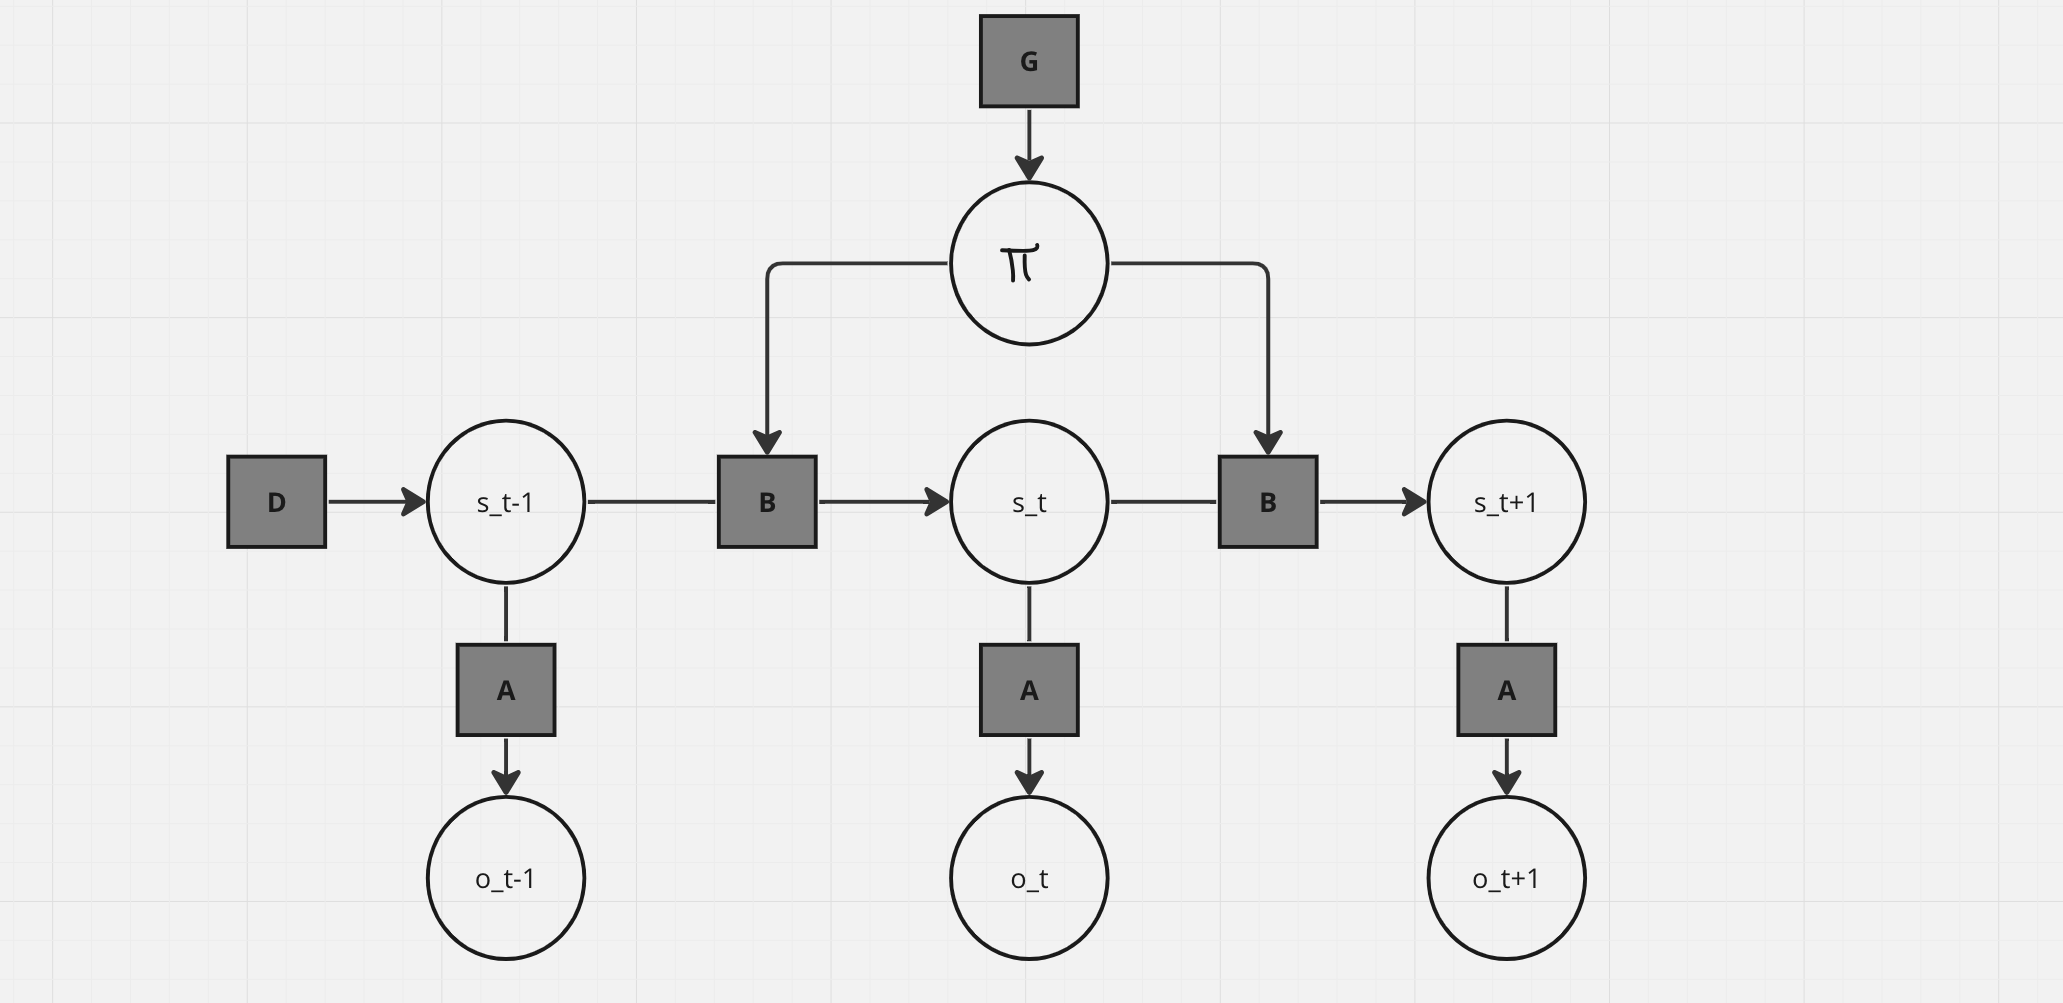

The model is defined  with the following quantities (largely following notation in [4]):

- Likelihood is a categroical distribution over observations given a hidden state

$$
P(o_t | s_t) = \text{Cat}(\bf{A})
$$
$$
A_{ij} = P(o_t = i | s_t = j)
$$

- State transistion. There is one state transition matrix $\bf{B}$ for each possible action. It encodes the probability of transition from one state to another under a certain action.

$$
P(s_{t+1} | s_t, \pi) = \text{Cat}(\bf{B}_{\pi t}) \\
$$

- Empirical priors over initial state and preference of observations

$$
P(s_1) = \text{Cat}(\bf{D})
$$
$$
P(o_t | C) = \text{Cat}(\bf{C_t})
$$


- Policies

$$
P(\pi | \gamma) = \sigma(-\gamma \cdot G(\pi))
$$
$$
G(\pi)  = \sum_{\tau} G(\pi, \tau)
$$
$$
G(\pi, \tau) = \mathbb{E}_{q(s_t, o_t, A|\pi)}[\ln Q(A) -\ln Q(A | s_t, o_t, \pi)] + D_{KL}[q(o_t| \pi) || p(o_t | C)] + \mathbb{E}_{q(s_t, o_t, A|\pi)} H[p(o_t | s_t)]
$$


- Parameters, these are the priors over the precision $\gamma$ and likelihood matrix $\bf{A}$

$$
P(\bf{A}) = Dir(a)
$$
$$
P(\gamma) = \Gamma(1, \beta)
$$


We can now write down the full joint distribution over a sequence of states, $\tilde{s}$, and observations, $\tilde{o}$, under policy $\pi$. Note we are assuming that an observation at a given time is dependant only on the state at the same time and at state at a given time is dependent only on the state prior to it and the action taken.

$$
P(\tilde{o}, \tilde{s}, \pi, \bf{A}, \gamma) = P(\pi | \gamma)P(\gamma)P(A) P(s_1)\prod_{t=2}^{T}P(o_t | s_t)P(s_t | s_{t-1}, \pi)
$$


### What actually happens during active inference

- 
- 


There are two types of updates that happen in an active inference agent:
- Inference - updates of beliefs about states.
- Learning - updates of beliefs about parameters (for e.g the precision $\gamma$ or dirichelet concentration $a$ from above)  


References:

[1] Active Inference Book: https://direct.mit.edu/books/oa-monograph/5299/Active-InferenceThe-Free-Energy-Principle-in-Mind

[2] Blog post: https://medium.com/@solopchuk/free-energy-action-value-and-curiosity-514097bccc02

[3] Blog post: https://medium.com/@solopchuk/tutorial-on-active-inference-30edcf50f5dc
    
[4] Computational mechanisms of curiosity and goal-directed exploration - https://www.biorxiv.org/content/biorxiv/early/2018/09/07/411272.full.pdf

[5] Discussion Paper - Active inference and epistemic value - https://www.fil.ion.ucl.ac.uk/~karl/Active%20inference%20and%20epistemic%20value.pdf

[6] Pymdp python package - https://pymdp-rtd.readthedocs.io/en/latest/notebooks/active_inference_from_scratch.html